In [1]:
from sklearn import datasets, cross_validation, metrics
import tensorflow as tf

import skflow
# from skflow import monitors
from scipy import misc
import os
import numpy as np
from scipy.stats import describe
import matplotlib.pyplot as plt;
%matplotlib inline

### Follow similar steps to load all the images as an array of MxN where N=256*256

In [2]:
emmap = {'0': 'NE',
                      '1': 'AN', # Angry
                      '2': 'CO', # contempt
                      '3': 'DI', # disgust
                      '4': 'AF', # afraid
                      '5': 'HA', # happy
                      '6': 'SA', # sad
                      '7': 'SU', # surprised
                      '8': 'NA'  # not available
}
emotion_map = dict(zip(emmap.values(),emmap.keys()));

In [3]:
from scipy.misc import imread
inputDir = '/Users/pulsar/Documents/compneuroproj/cropped_images'
onlyfiles = [f for f in os.listdir(inputDir) if os.path.isfile(os.path.join(inputDir, f))]
print(len(onlyfiles))

1401


In [4]:
from matplotlib import pyplot
from PIL import Image
i = 0;
images = []
for ff in onlyfiles:
    try:
        image = Image.open(inputDir+'/'+ff)
        image = image.convert('RGB');
        image = np.asarray(image, dtype='float32')
        images.append(image);
    except ValueError:
        images.append(image);
        continue
labels = []
for ff in onlyfiles:
    try:
        labels.append(emotion_map[ff[5:7]])
    except ValueError:
        print ('oops');
        break;
labels = [int(l) for l in labels];
labels = np.array([labels]).T

In [5]:
np.array(images).shape

(1401, 160, 160, 3)

In [6]:
X = np.array(images);
y = labels;

# Split X into test and train sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,
                                        test_size=0.2, random_state=42)
# Split X_train for validation data
X_train, X_val, y_train, y_val = cross_validation.train_test_split(X_train, 
                                    y_train, test_size=0.2,random_state=42)
X_train /= 255;
X_test /= 255;

In [7]:
X_train.shape

(896, 160, 160, 3)

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import plot, to_graph


* INPUT [32x32x3] will hold the raw pixel values of the image, in this case an image of width 32, height 32, and with three color channels R,G,B.
* CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and the region they are connected to in the input volume. This may result in volume such as [32x32x12].
* RELU layer will apply an elementwise activation function, such as the max(0,x)max(0,x) thresholding at zero. This leaves the size of the volume unchanged ([32x32x12]).
* POOL layer will perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as [16x16x12].
* FC (i.e. fully-connected) layer will compute the class scores, resulting in volume of size [1x1x10], where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.

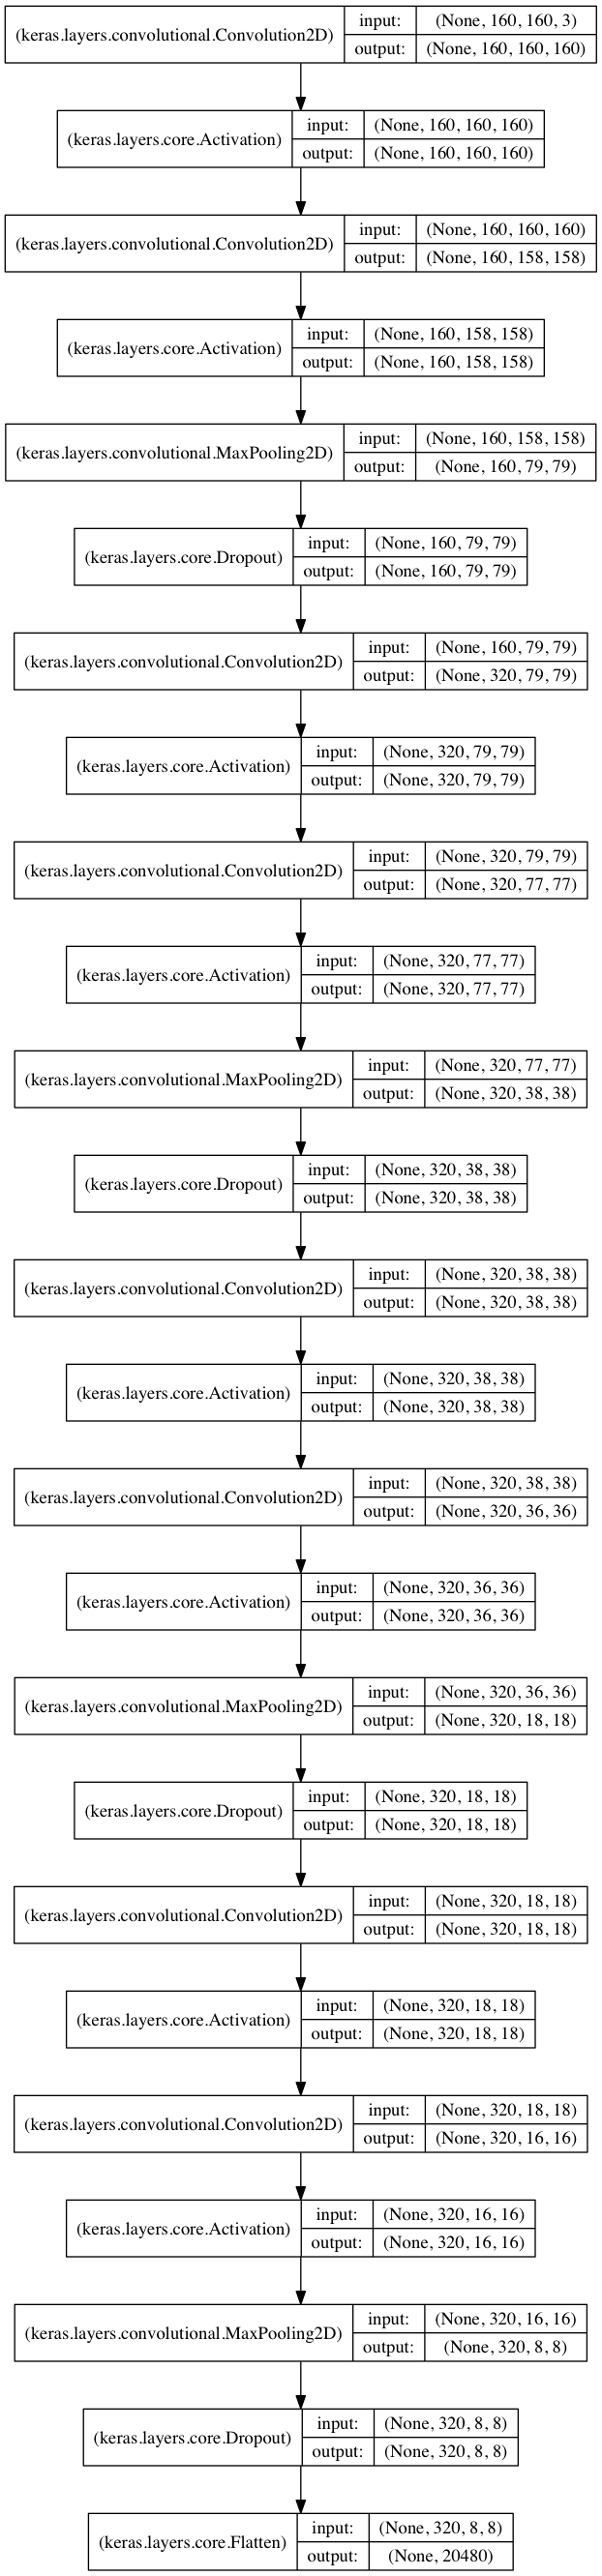

In [33]:
def make_network():
    model = Sequential();
    model.add(Convolution2D(160, 3, 3, border_mode='same', dim_ordering='tf',
                           input_shape=(160, 160, 3)));
    model.add(Activation('relu'));
    model.add(Convolution2D(160, 3, 3))
    model.add(Activation('relu'));
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25));
    
    model.add(Convolution2D(320, 3, 3, border_mode='same'));
    model.add(Activation('relu'));
    model.add(Convolution2D(320, 3, 3))
    model.add(Activation('relu'));
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25));
    
    model.add(Convolution2D(320, 3, 3, border_mode='same'));
    model.add(Activation('relu'));
    model.add(Convolution2D(320, 3, 3))
    model.add(Activation('relu'));
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25));
    
    model.add(Convolution2D(320, 3, 3, border_mode='same'));
    model.add(Activation('relu'));
    model.add(Convolution2D(320, 3, 3))
    model.add(Activation('relu'));
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25));
    
    model.add(Flatten());
    
    
#     model.add(Convolution2D())
    
    return model

def make_network2():
    ## this is the model used to classify images in the CIFAR10 dataset
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same',
                           input_shape=(3, 32, 32)))
    model.add(Activation('relu'))
    model.add(Convolution2D(32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))
 
    return model


model = make_network();
# model2 = make_network2();
graph = to_graph(model, show_shape=True)
# graph2 = to_graph(model2, show_shape=True)
graph.write_png("model.png")
# graph2.write_png("model_cifar.png")
from IPython.display import Image
Image(filename='model.png') 